# Possible solution to assignment 3

This notebook contains a worked solution to assignment 3, training a neural network classifier with ```pytorch```.

Please note that this is *not* comprehensive - this is not then only solution, with all others being wrong. This is just a possible solution, based on me having spent some time looking at the data.

### Loading packages

Note how here I'm using ```TfidfVectorizer()``` instead of ```CountVectorizer()```. This seemed to perform better empirically, producing smoother learning curves and higher accuracies on the test data.

In [16]:
# system tools
import os

# pytorch
os.system('pip install --upgrade pip datasets torch')
import torch
import torch.nn as nn

# data processing
import pandas as pd
import numpy as np

# huggingface datasets
from datasets import load_dataset

# scikit learn tools
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# plotting tools
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)


## Define Neural Network model class

Notice how here I'm using a _ReLU_ activation function. After experimenting a little, I found that _ReLU_ was overfitting much less quickly than using _Sigmoid_ activation functions. The final layer is still _Sigmoid_ as we're trying to make a binary prediction.

In [17]:
# Neural network model
class Model(nn.Module):
    def __init__(self, n_input_features):
        super().__init__()
        self.linear1 = nn.Linear(n_input_features, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 1)

    def forward(self, x):
        leaky_relu = nn.LeakyReLU(0.2)
        # Linear -> ReLU
        x = self.linear1(x)
        x = leaky_relu(x)
        # Linear -> ReLU
        x = self.linear2(x)
        x = leaky_relu(x)
        # Linear -> Sigmoid
        x = self.linear3(x)
        y_pred = torch.sigmoid(x)
        return y_pred

In [18]:
# # Logistic regression model
# class Model(nn.Module):
#     """ class initializing a simple logistic regression classifier
#     """
#     def __init__(self, n_input_features):
#          super().__init__()
#          self.linear = torch.nn.Linear(n_input_features, 1)

#     def forward(self, x):
#         x = self.linear(x)
#         y_pred = torch.sigmoid(x)
#         return y_pred

__Load data__

For this exercise, I decided to use the "Rotten Tomatoes" dataset from Huggingface. Technically, any other ```Huggingface``` dataset should fit in here, as long as it has training-validation-test datasets and binary labels.

In [19]:
# Import the dataframe
data = pd.read_csv("/work/exam/ASD_classification/data/dataframes/data_eigstig_age3_text_label.csv")

I start by explicitly separating the different splits in the data.

In [20]:
# Split dataset into train, test, val (70, 15, 15)
train, test = train_test_split(data, test_size=0.15)
train, val = train_test_split(train, test_size=0.15)

# Turning the split dataframes into dicts
train = Dataset.from_dict(train)
val = Dataset.from_dict(val)
test = Dataset.from_dict(test)

__Vectorize__

I then define how to use my vectorizer class. I originally trained by using ```lowercase=True```and using removing highly common English words (what are called "stopwords" in text mining literature). However, this was a bad idea - the data is already lowercase, and removing stopwords reduced performance. I suspect that this is because I was actually removing a lot of common words which are shared across training and test data, meaning it was harder for the model to generalize.

In [21]:
# vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                            #lowercase=True, 
                            #stop_words="english", 
                            #max_df=0.9, 
                            #min_df=0.1,
                            max_features=500)

I first vectorize the training data and conver the labels to something that ```pytorch``` can use. 

After than, I transform the validation and test data using the vectorizer that was fit to the training data. Be careful here that you don't use ```.fit_transform()``` on the validation and training data again!

In [22]:
# vectorized training data -> to tensors
train_vect = vectorizer.fit_transform(train["text"])
train_vect = torch.tensor(train_vect.toarray(), dtype=torch.float)

# labels
train_label = torch.tensor(list(train["label"]), dtype=torch.float)
train_label = train_label.view(train_label.shape[0], 1)

In [23]:
# vectorized validation data -> to tensors
val_vect = vectorizer.transform(val["text"])
val_vect = torch.tensor(val_vect.toarray(), dtype=torch.float)

# labels
val_label = torch.tensor(list(val["label"]), dtype=torch.float)
val_label = val_label.view(val_label.shape[0], 1)

In [24]:
# vectorized test data -> to tensors
test_vect = vectorizer.transform(test["text"])
test_vect = torch.tensor(test_vect.toarray(), dtype=torch.float)

# labels
test_label = torch.tensor(list(test["label"]), dtype=torch.float)
test_label = test_label.view(test_label.shape[0], 1)

__Parameters__

I then initialise my model just like we did in class last time. The only difference here is that I'm adding a fairly small learning rate to ```ADAM``` to avoid overfitting - note that ```1e-4``` is scientific notation, so that's 0.0001.

This learning rate was decided upon through trial and error. We'll see in class soon how we can do _hyperparameter search_.

In [25]:
# Weights
## Weights for class 0:
w0 = 2435/(2 * 1730)
## Weights for class 1:
w1 = 2435/(2 * 705)
#weights = {0 : w0, 1 : w1}
weights = torch.Tensor([0.000000000001])
print(weights.size())
#weights = {0:w0, 1:w1}

torch.Size([1])


In [26]:
# initialize model
n_samples, n_features = train_vect.shape
model = Model(n_input_features=n_features)

# define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=1e-3)

__Train__

I create empty lists into which I'm going to save the training and validation loss after every epoch. This is because we can actually learn a lot about _how well_ a model is learning by inspecting the loss curves. There's a nice introduction to this idea [here](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

Note that we could do the same for an _accuracy curve_ - i.e. how much is accuracy improving over time. 

- How might we implement that?
- What would we expect to see if a model is learning well?

In [27]:
# for plotting
train_loss_history = []
val_loss_history = []

We then train for 1000 epochs, and the loop here is very similar to what we've worked on in-class. The only difference is that after we've run the backprop and updated the gradients, we then test how well the model performs on the validation data during this epoch.

Notice that we need to do two things here - firstly, we set ```torch.no_grad()``` to make sure that we don't accidentally update any gradients that we don't want to update. We also then have to set the model to evaluation mode using ```model.eval()```. This make sure that we don't do a forward pass over the validation data and end up learning from it!

In [28]:
# train
epochs = 1000
print("[INFO:] Training classifier...")

# loop for epochs
for epoch in range(epochs):
    
    # forward
    y_hat = model(train_vect)

    # backward
    loss = criterion(y_hat, train_label)
    train_loss_history.append(loss)

    # backpropagation
    loss.backward()
    
    # take step, reset
    optimizer.step()
    optimizer.zero_grad()
    
    # Validation Loop 
    with torch.no_grad(): 
        # set to eval mode
        model.eval() 

        # make predictions
        predicted_outputs = model(val_vect) 

        # metrics
        val_loss = criterion(predicted_outputs, val_label) 

        # append
        val_loss_history.append(val_loss) 

    # some print to see that it is running
    if (epoch + 1) % 100 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f}")

print("[INFO:] Finished traning!")

[INFO:] Training classifier...
epoch: 100, loss = 0.5230
epoch: 200, loss = 0.4434
epoch: 300, loss = 0.3782
epoch: 400, loss = 0.3208
epoch: 500, loss = 0.2962
epoch: 600, loss = 0.2896
epoch: 700, loss = 0.2875
epoch: 800, loss = 0.2865
epoch: 900, loss = 0.2859
epoch: 1000, loss = 0.2856
[INFO:] Finished traning!


__Evaluate__

Once the model has trained, we can then inspect performance. Since we only trained on the train and validation splits, we can then check how our accuracy looks when evaluating the test data. This test data has not been at all during training, so it's completely new to the model. If it performs well on this held out data, that implies that the model has learned to generalize well.

In [29]:
# Plot
predicted = model(test_vect).detach().numpy()
print(classification_report(test_label, 
                            np.where(predicted > 0.5, 1, 0),
                            target_names = ["TD", "ASD"]))

              precision    recall  f1-score   support

          TD       0.62      0.65      0.63       351
         ASD       0.66      0.63      0.64       380

    accuracy                           0.64       731
   macro avg       0.64      0.64      0.64       731
weighted avg       0.64      0.64      0.64       731



We can also produce a simple plot showing how training and validation loss decrease over time. The blue line is the training loss; orange is the validation loss.

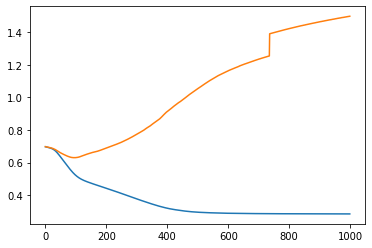

In [30]:
train_loss = [val.item() for val in train_loss_history]
val_loss = [val.item() for val in val_loss_history]

fig, ax = plt.subplots()
ax.plot(train_loss)
ax.plot(val_loss)

- Given the loss curves and the classification report, how well is this model performing?
- If we wanted to make improvements, what might we want to change?
- How do we make principled decisions about which hyperparameters to change?
  - Hint: One way to do it to just use [brute force](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)!